# Project 2
Estimating $\beta$-convergence in GDP growth.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
%load_ext autoreload
%autoreload 2


In [45]:
data = pd.read_csv('data/growth.csv')
labs = pd.read_csv('data/labels.csv')

In [46]:
print(f'Number of obs. in dataset: {data.shape[0]}')
print(f'Number of obs. with GDP growth (outcome) data: {data.gdp_growth.notna().sum()}')
print(f'Number of obs. with initial GDP (main var) data: {data.lgdp_initial.notna().sum()}')
idx = (data.gdp_growth.notna()) & (data.lgdp_initial.notna())
print(f'Max number of obs. for analysis: {data[idx].shape[0]}')
data_org = data.copy()
data = data_org[idx]

Number of obs. in dataset: 214
Number of obs. with GDP growth (outcome) data: 102
Number of obs. with initial GDP (main var) data: 109
Max number of obs. for analysis: 102


In [47]:
pop_idx = labs.label.str.contains('Population')
labs[pop_idx]

,variable,label,source
125,PopulationtotalSPPOPTOTL,"Population, total [SP.POP.TOTL]",ANRR
126,Populationages014oftotal,Population ages 0-14 (% of total) [SP.POP.0014...,ANRR
127,Populationages1564oftota,Population ages 15-64 (% of total) [SP.POP.156...,ANRR
190,pop1,Population in 1 CE,QG
191,pop1000,Population in 1000 CE,QG
192,pop1500,Population in 1500 CE,QG
193,pd1,Population density in 1 CE,QG
194,pd1000,Population density in 1000 CE,QG
195,pd1500,Population density in 1500 CE,QG
366,population_initial,Population in 1970,WB


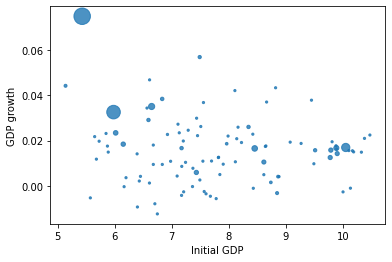

In [48]:
# Printing graph of apparent relation between initial GDP and GDP growth 
f, ax = plt.subplots(1,1)
s = [max(5,np.exp(i)/3000000) for i in data.lpop_initial.values] # marker size
ax.scatter(data.lgdp_initial,data.gdp_growth,s=s,alpha=0.8)
ax.set_xlabel('Initial GDP')
ax.set_ylabel('GDP growth')
plt.show()

In [49]:
# Creating groups for variables, and setting regex patterns
groups = {'Central variables': {'pattern': '(gdp per capita in 1970 [(log)])|(annual growth in gdp per capita, 1970-2020)'.encode('unicode-escape'), 'vars': []}, 
          'Geographic': {'pattern': '(area)|(distance)|(land)|(geo)|(tropic)|(coast)|(africa)|(asia)|(oceania)|(europe)|(america)|(temperature)|(elevation)|(precipitation)|(rough)|(latitude)'.encode('unicode-escape'), 'vars': []}, 
          'Democracy and institutions': {'pattern': '(democracy)|(education)'.encode('unicode-escape'), 'vars': []}, 
          'Population': {'pattern': '((growth in )*population[,]* (density|in)*)|(mortal)|(fever)|(ultraviolet)|(protestant)|(cathol)|(muslim)|(religion)|(life expect)|(genetic diversity)'.encode('unicode-escape'), 'vars': []}, 
          'Economic': {'pattern': '(investment)|(gdp)|(business)|(market)'.encode('unicode-escape'), 'vars': []}, 
          'Ressources': {'pattern': '(mineral)|(oil)'.encode('unicode-escape'), 'vars': []}, 
          'Historical': {'pattern': '(colony)|(1900)|(neolithic)|(origin)'.encode('unicode-escape'), 'vars': []}
         
         }

In [50]:
# Loop over all variables in data, and allocate to groups based on patterns above
for i in data.columns:
    if i in labs.variable.values:
        res = labs.set_index('variable').loc[[i]].label.values
        if type(res) is np.ndarray:
            res = res[-1]
#         print(f'{i:40s}', res)
        
    for group, group_dict in groups.items():
        if re.search(group_dict['pattern'], res.lower().encode('unicode-escape')) is not None:
            group_dict['vars'].append(i)

# List of all variables put in groups            
grouped_vars = []
for group, group_dict in groups.items():
    grouped_vars += group_dict['vars']

# Print all variables, and the groups they're allocated to
def print_varinfo(variables):
    for i in sorted(variables):
        if i in labs.variable.values:
            res = labs.set_index('variable').loc[[i]].label.values
            if type(res) is np.ndarray:
                res = res[-1]

            in_groups = ''
            for group, group_dict in groups.items():
                if i in group_dict['vars']:
                    in_groups += (group + ', ')
            if in_groups == '':
                in_groups = 'None'
            print(f'{i:40s} {res}')
            print(f'{"":5s} in groups: {in_groups}')

print_varinfo(data.columns)

abslat                                   Absolute latitude
      in groups: Geographic, 
africa                                   Africa dummy
      in groups: Geographic, 
americas                                 Americas dummy
      in groups: Geographic, 
area                                     Total land area
      in groups: Geographic, 
area_ar                                  Arable land area
      in groups: Geographic, 
asia                                     Asia dummy
      in groups: Geographic, 
capital_growth_pct_gdp_initial           Gross capital formation in 1970 (% of GDP)
      in groups: Economic, 
capital_growth_pct_gdp_now               Gross capital formation in 2020 (% of GDP)
      in groups: Economic, 
cenlong                                  Geodesic centroid longitude
      in groups: Geographic, 
code                                     World Bank country code
      in groups: None
cons00a                                  constraint on executive in 1900
 

In [51]:
# Print number of non missing observations for each group of variables
for group, group_dict in groups.items():
    group_nonmiss = data.notna()[group_dict['vars']].all(axis='columns').sum()
    print(f'"{group}" contains the following {len(group_dict["vars"])} variables and has {group_nonmiss} non missing values')
    for var in group_dict['vars']:
        print(f'{"":10s} {var:30s} ----> {data[var].notna().sum(): 4d} non-missing')

"Central variables" contains the following 2 variables and has 102 non missing values
           gdp_growth                     ---->  102 non-missing
           lgdp_initial                   ---->  102 non-missing
"Geographic" contains the following 23 variables and has 47 non missing values
           tropicar                       ---->   93 non-missing
           distcr                         ---->   93 non-missing
           distc                          ---->   93 non-missing
           distr                          ---->   93 non-missing
           landlock                       ---->   98 non-missing
           lt100km                        ---->   51 non-missing
           suitavg                        ---->   92 non-missing
           temp                           ---->  101 non-missing
           elevavg                        ---->  101 non-missing
           elevstd                        ---->   92 non-missing
           kgatr                          ---->   94 no

In [52]:
# Print variables not in group
no_groups = [i for i in data.columns if i not in grouped_vars]
print_varinfo(no_groups)

code                                     World Bank country code
      in groups: None


In [53]:
def removefromgroup(var, group):
    to_keep = list(set(groups[group]['vars']))
    try: 
        to_keep.pop(to_keep.index(var)) 
    except:
        print(f'{var} not in {group}')
    groups[group]['vars'] = to_keep
    return

In [54]:
# Group dict with variables that do not keep less that 90 obervations individually
def restrict_vars(n):
    res_dict = groups
    for g, g_dict in res_dict.items():
        for var in g_dict['vars']:
            if data[var].notna().sum() < n:
                removefromgroup(var,g)
    return res_dict

groups_95 = restrict_vars(95)
vars_95 = []
for group, group_dict in groups.items():
    vars_95 += group_dict['vars']

In [55]:
# Print number of non missing observations for each group of variables
for group, group_dict in groups_95.items():
    group_nonmiss = data.notna()[group_dict['vars']].all(axis='columns').sum()
    print(f'"{group}" contains the following {len(group_dict["vars"])} variables and has {group_nonmiss} non missing values')
    for var in group_dict['vars']:
        print(f'{"":10s} {var:30s} ----> {data[var].notna().sum(): 4d} non-missing')
        
print('\n\n')
print(f'Using this set of variables {len(vars_95)} variables leaves us with {data.notna()[vars_95].all(axis="columns").sum()} observations in total')

"Central variables" contains the following 2 variables and has 102 non missing values
           gdp_growth                     ---->  102 non-missing
           lgdp_initial                   ---->  102 non-missing
"Geographic" contains the following 14 variables and has 96 non missing values
           africa                         ---->  102 non-missing
           precip                         ---->  101 non-missing
           europe                         ---->  102 non-missing
           asia                           ---->  102 non-missing
           abslat                         ---->  101 non-missing
           cenlong                        ---->  102 non-missing
           landlock                       ---->   98 non-missing
           elevavg                        ---->  101 non-missing
           area_ar                        ---->  100 non-missing
           oceania                        ---->  102 non-missing
           area                           ---->  102 no

In [77]:
reg_data = data[data[vars_95].notna().all(axis='columns')][vars_95].reset_index(drop=True).copy().drop_duplicates()
reg_data = reg_data.iloc[:,2:]

In [138]:
import sys
sys.path.insert(1, '/home/matiasp/University/m2/advanced_microeconometrics/micropy/')
from highdim import LassoIV
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
lassoiv = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = reg_data, 
                  estimator='ppol', lamb_method='bcch', c = 1.1,
                  normalize=True).fit(significant_lvl=.05)

For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 0.02435
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.65072
------------------------------------------------------------------
lgdp_initial estimate: -0.000923
Confident interval: [-0.003287  0.001441]


In [140]:
lassoiv = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = reg_data, 
                  estimator='ppol', lamb_method='brt', c = 1.1,
                  normalize=True).fit(significant_lvl=.05)

For gdp_growth ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.00565
For lgdp_initial ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.5327
------------------------------------------------------------------
lgdp_initial estimate: -0.002246
Confident interval: [-0.006314  0.001823]


In [141]:
lassoiv = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = reg_data, 
                  estimator='pdl', lamb_method='bcch', c = 1.1,
                  normalize=True).fit(significant_lvl=.05)

For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 0.02435
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.65072
For gdp_growth ~ X
The Belloni-Chen-Chernozhukov-Hansen lambda is: 0.02439
------------------------------------------------------------------
lgdp_initial estimate: -0.000923
Confident interval: [-0.003208  0.001362]


In [142]:
lassoiv = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = reg_data, 
                  estimator='pdl', lamb_method='brt', c = 1.1,
                  normalize=True).fit(significant_lvl=.05)

For gdp_growth ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.00565
For lgdp_initial ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.5327
For gdp_growth ~ X
The Bickel-Ritov-Tsybakov lambda is: 0.00566
------------------------------------------------------------------
lgdp_initial estimate: -0.001497
Confident interval: [-0.005411  0.002416]


In [427]:
reg_data.to_csv('regdata_95.csv')